🧑**Roe Barlev - 209510981** 🦸

🧑**Ron Dudkman - 316010750** 🦸

# 1 Setup 

Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!nvidia-smi -L

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
GPU 0: Tesla T4 (UUID: GPU-377efaf8-b009-9b8a-c01b-711a097a3ac0)


## 1.1 Libreries

In [2]:
!pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import ipyplot
import os.path
import zipfile
from glob import glob
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchvision.models import vgg19
from torchvision.ops import *
from torch.nn import functional as F
from torch.optim import NAdam, Adam
from torch.optim import lr_scheduler

from datetime import datetime

import pickle

import random
from tqdm import tqdm
import tifffile as tif
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)

from requests import get
from torchsummary import summary


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


## 1.2 Config

In [4]:
config = {}

# Link for the bowl dataset: https://www.kaggle.com/competitions/data-science-bowl-2018/data
# Link for the CVC dataset : https://www.kaggle.com/datasets/balraj98/cvcclinicdb

##################### Configuration: ######################
''' choose True if u need to arrange your data for the first time'''
#config['first_time_data_arrangement'] = True
config['first_time_data_arrangement'] = False

''' choose if you want to use the interpolation technique '''
#config ['use_interpolation'] = True
config['use_interpolation']= False

''' choose the dataset u want to work with'''
#config['dataset'] = 'bowl'
config['dataset']= 'CVC'

''' change directories paths'''
config['data_path'] = '/content/gdrive/MyDrive/שנה א׳/סמסטר ב׳/למידה עמוקה/שיעורי בית/Roe Ron/project_209510981_316010750/Datasets/splitted augmented data/' 
config['output_path'] = '/content/gdrive/MyDrive/שנה א׳/סמסטר ב׳/למידה עמוקה/שיעורי בית/Roe Ron/project_209510981_316010750/output/'

#############################################################
config['CVC_ClinicDB_zip_path'] = config['data_path']+'CVC-ClinicDB.zip'
config['bowl_2018_zip_path'] = config['data_path']+'data-science-bowl-2018.zip'
config['bowl_2018_train_zip_path'] = '/content/data-science-bowl-2018/stage1_train.zip'

config['CVC_ClinicDB_new_zip_path'] = config['data_path']+'CVC-ClinicDB-new_data.zip'
config['bowl_2018_new_zip_path'] = config['data_path']+'bowl_dataset-new_data.zip'

if config['dataset']=='bowl':
  config['input_w']=256
  config['input_h']=256
  config['lr'] = lr = 1e-4
  config['batch_size']=16
else:
  config['input_w']=384
  config['input_h']=288
  #config['lr'] = lr = 0.001 
  config['lr'] = 1e-4
  if config['use_interpolation'] == True:
    config['batch_size']=16
  elif config['use_interpolation'] == False: 
    config ['batch_size']=4 

config['notebook_name'] =  get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

config['name']=None
config['epochs']=30

config['eps'] = 1e-07
config['num_workers']=2
config['squeeze_ratio']=8
config['smooth'] = 1e-15

config['early_stopping_patience'] = 15
config['scheduler_reduce_lr_factor'] = 0.1
config['scheduler_patience'] = 10
#############################################################

## 1.3 Utils

In [5]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

In [6]:
def unzip_by_path(src_zip_path, dest_unzip_path="/content/"):
  
  src_zip_name = src_zip_path.split('.')[0].split('/')[-1] #takes the first name before the .zip ending
  dest_unzip_path = dest_unzip_path + src_zip_name 

  with zipfile.ZipFile(src_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_unzip_path)

In [7]:
def print_both(*args,output_file_path):
    output_file = open(output_file_path, "a") #open file to save all prints to it
    toprint = ' '.join([str(arg) for arg in args])
    print(toprint)
    output_file.write(toprint)
    output_file.close()


In [8]:
def dict_to_txt(dict_,output_file_path):
  ''' save dict to txt file'''

  output_file = open(output_file_path, "w") #open file to save all prints to it
  for dict_ele in str(dict_).split(','):
    output_file.write(str(dict_ele)+'\n')
  output_file.close()


In [9]:
def save_list(list_,output_path):
  with open(output_path, "wb") as fp:   #Pickling
    pickle.dump(list_, fp)
    fp.close()


def load_list(output_path):
  with open(output_path, "rb") as fp:   # Unpickling
    list_ = pickle.load(fp)
    fp.close()
  
  return list_

# 2 Datasets extraction to local env

Extract Datasets to local workspace

In [10]:
src_zip_paths = [config['CVC_ClinicDB_zip_path'],
                 config['bowl_2018_zip_path'],
                 config['bowl_2018_train_zip_path'],
                 config['CVC_ClinicDB_new_zip_path'],
                 config['bowl_2018_new_zip_path']]

if config['first_time_data_arrangement']: # if it is the first time foro creating the zip new data
  if config['dataset']=='bowl':
    unzip_by_path(src_zip_paths[1], dest_unzip_path="/content/")
    unzip_by_path(src_zip_paths[2], dest_unzip_path="/content/bowl_dataset/") 
  else:
    unzip_by_path(src_zip_paths[0], dest_unzip_path="/content/")

elif not config['first_time_data_arrangement']: #when you have the new data just unzip it to this location
  if config['dataset']=='bowl':
    unzip_by_path(src_zip_paths[4], dest_unzip_path="/content/") 
  else:
    unzip_by_path(src_zip_paths[3], dest_unzip_path="/content/")

#3 CVC-ClinicDB

##3.1 Utils for this dataset

In [11]:

def load_data(images_folder_path, masks_folder_path):
  '''load the data to 2 path lists for images and masks.'''

  images = [images_folder_path+name for name in os.listdir(images_folder_path)]
  masks = [masks_folder_path+name for name in os.listdir(masks_folder_path)]
  return images, masks

def read_data_to_list(images_path, masks_path):
    """ Read the image and mask from the given images and masks lists of paths. """

    images = []
    masks =[]
    for xi,yi in zip(images_path,masks_path):
      images.append(cv2.imread(xi, cv2.IMREAD_COLOR))
      masks.append(cv2.imread(yi, cv2.IMREAD_COLOR))
    return images, masks

def split_data(images,masks):
  ''' split the data to 80-10-10'''
  train_size=int(0.8*len(images))
  valid_size=int(0.1*len(images))
  test_size=int(0.1*len(images))
  
  train_x, test_x = train_test_split(images, test_size=test_size, random_state=0)
  train_y, test_y = train_test_split(masks, test_size=test_size, random_state=0)

  train_x, valid_x = train_test_split(train_x, test_size=valid_size, random_state=0)
  train_y, valid_y = train_test_split(train_y, test_size=valid_size, random_state=0)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
    
def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

##3.2 Read and learn the data

Read images and masks paths & read images and masks as images

In [12]:
if config['first_time_data_arrangement']:
  CVC_images_path, CVC_masks_path = load_data("/content/CVC-ClinicDB/PNG/Original/", "/content/CVC-ClinicDB/PNG/Ground Truth/")
  CVC_images, CVC_masks = read_data_to_list(CVC_images_path, CVC_masks_path)

  print("Numbers of images for CVC-ClinicDB: " + str(len(CVC_images)))
  print("Numbers of masks for CVC-ClinicDB: " + str(len(CVC_masks_path)))


Images shape check

In [13]:
if config['first_time_data_arrangement']:
  check_images_shape = {img.shape for img in CVC_images} #create a set of values, if we get 1 element it means all images are the same size
  print("images shape is (H,W,C):"+str(check_images_shape))
  check_masks_shape = {mask.shape for mask in CVC_masks} #create a set of values, if we get 1 element it means all images are the same size
  print("masks shape is (H,W,C):"+str(check_masks_shape))

## 3.3 Split the data

In [14]:
if config['first_time_data_arrangement']:
  (CVC_train_images_path, CVC_train_masks_path), (CVC_valid_images_path, CVC_valid_masks_path), (CVC_test_images_path, CVC_test_masks_path) = split_data(CVC_images_path,CVC_masks_path)
  print("Numbers of CVC_train_images: " + str(len(CVC_train_images_path)))
  print("Numbers of CVC_valid_images: " + str(len(CVC_valid_images_path)))
  print("Numbers of CVC_test_images: " + str(len(CVC_test_images_path)))
  print("Numbers of CVC_train_masks: " + str(len(CVC_train_masks_path)))
  print("Numbers of CVC_valid_masks: " + str(len(CVC_valid_masks_path)))
  print("Numbers of CVC_test_masks: " + str(len(CVC_test_masks_path)))


## 3.4 Data examples

Show the data by images and masks

In [15]:
if config['first_time_data_arrangement']:
  ipyplot.plot_images(CVC_images, max_images=7, img_width=150, force_b64=True)
  ipyplot.plot_images(CVC_masks, max_images=7, img_width=150, force_b64=True)

Show images and masks by paths

In [16]:
if config['first_time_data_arrangement']:
  ipyplot.plot_images(CVC_train_images_path, max_images=7, img_width=150, force_b64=True)
  ipyplot.plot_images(CVC_train_masks_path, max_images=7, img_width=150, force_b64=True)

## 3.5 Augmentations

In [17]:
def augment_data(images, masks, W, H, save_path, augment=True):
    """ Performing data augmentation. """
    #W = 384
    #H = 288
    crop_size = (H-32, W-32)
    size = (W, H)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:
            ## Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = MedianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']

            aug = GaussianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1



## 3.6 Save aug. data 

Create directories to save augmentations later on

In [18]:
if config['first_time_data_arrangement']:
  create_dir("/content/CVC-ClinicDB/new_data/train/image/")
  create_dir("/content/CVC-ClinicDB/new_data/train/mask/")
  create_dir("/content/CVC-ClinicDB/new_data/valid/image/")
  create_dir("/content/CVC-ClinicDB/new_data/valid/mask/")
  create_dir("/content/CVC-ClinicDB/new_data/test/image/")
  create_dir("/content/CVC-ClinicDB/new_data/test/mask/")


Use augmentations

In [19]:
if config['first_time_data_arrangement']:
  W, H = [config['input_w'], config['input_h']] #size to resize if needed after augmentations
  augment_data(CVC_train_images_path, CVC_train_masks_path, W, H, "/content/CVC-ClinicDB/new_data/train/", augment=True)
  augment_data(CVC_valid_images_path, CVC_valid_masks_path, W, H, "/content/CVC-ClinicDB/new_data/valid/", augment=False)
  augment_data(CVC_test_images_path, CVC_test_masks_path, W, H, "/content/CVC-ClinicDB/new_data/test/", augment=False)


### 3.6.1 Save aug data as ZIP file

In [20]:
if config['first_time_data_arrangement']: a=1 # if it is "a" first time a will be 1
elif not config['first_time_data_arrangement']: a=0 #not a first time "a" will be 0
#using shell commend to zip only if it is a first time.
!if [ $a -eq 1 ]; then zip -r /content/gdrive/MyDrive/CVC-ClinicDB-new_data.zip /content/CVC-ClinicDB/new_data; fi


## 3.7 Dataset class

define Dataset class 

In [21]:
class CvcClinicDbDataset(Dataset):
    def __init__(self, CVC_images_folder, CVC_masks_folder, transform = None):
        '''define self parameters, root folders to read from images and masks '''
        self.CVC_images_folder = CVC_images_folder
        self.CVC_masks_folder = CVC_masks_folder
        self.transform = transform
        # get to self parameters images and masks path lists for when we want to get item from dataset
        self.CVC_images_path, self.CVC_masks_path = load_data(self.CVC_images_folder, self.CVC_masks_folder)

    def __getitem__(self, index):
        CVC_image_path = self.CVC_images_path[index]
        CVC_mask_path = self.CVC_masks_path[index]
        
        CVC_image = cv2.imread(CVC_image_path, cv2.IMREAD_COLOR).astype(np.float32)/255.0 #need to read them as float for NN
        CVC_mask = cv2.imread(CVC_mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0 #need to read them as float for NN

        sample = {'image': CVC_image, 'mask': CVC_mask}
        if self.transform:
            #print("in transform!")
            sample = self.transform(sample)
        return sample


    def __len__(self):
        return len(self.CVC_images_path)

    def load_data(images_folder_path, masks_folder_path):
        '''load the data to 2 path lists for images and masks.'''

        images = [images_folder_path+name for name in os.listdir(images_folder_path)]
        masks = [masks_folder_path+name for name in os.listdir(masks_folder_path)]
        return images, masks


In [22]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = np.expand_dims(mask, axis=-1)
        mask = mask.transpose((2, 0, 1))
        #print(image)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

## 3.8 DataLoaders for train and validation

Load dataset class

In [23]:
CVC_clinic_DB_train = CvcClinicDbDataset("/content/CVC-ClinicDB-new_data/content/CVC-ClinicDB/new_data/train/image/", "/content/CVC-ClinicDB-new_data/content/CVC-ClinicDB/new_data/train/mask/",transform = ToTensor())

In [24]:
train_dataloader = DataLoader(CVC_clinic_DB_train, batch_size=config['batch_size'],
                        shuffle=True, num_workers= config['num_workers'])

In [25]:
CVC_clinic_DB_valid = CvcClinicDbDataset("/content/CVC-ClinicDB-new_data/content/CVC-ClinicDB/new_data/valid/image/", "/content/CVC-ClinicDB-new_data/content/CVC-ClinicDB/new_data/valid/mask/",transform = ToTensor())

In [26]:
valid_dataloader = DataLoader(CVC_clinic_DB_valid, batch_size=config['batch_size'],
                        shuffle=True, num_workers=config['num_workers'])

In [27]:
CVC_clinic_DB_test = CvcClinicDbDataset("/content/CVC-ClinicDB-new_data/content/CVC-ClinicDB/new_data/test/image/", "/content/CVC-ClinicDB-new_data/content/CVC-ClinicDB/new_data/test/mask/",transform = ToTensor())


In [28]:
test_dataloader = DataLoader(CVC_clinic_DB_test, batch_size=config['batch_size'],
                        shuffle=True, num_workers=config['num_workers'])

# 4 Data science bowl 2018

## 4.1 Utils for this dataset

In [ ]:
def load_data(images_folder_path, masks_folder_path):
  '''load the data to 2 path lists for images and masks.'''

  images = [images_folder_path+name for name in os.listdir(images_folder_path)]
  masks = [masks_folder_path+name for name in os.listdir(masks_folder_path)]
  return images, masks

def read_data_to_list(path_of_the_directory,path_to_save):
  """ Read the image and mask from the given images and masks lists of paths. """
  create_dir(path_to_save+ "image/")
  create_dir(path_to_save+ "mask/")
  images = []
  masks = []

  for filename in tqdm(os.listdir(path_of_the_directory)):
    f = os.path.join(path_of_the_directory,filename)
    bowl_image_path, bowl_masks_path = load_data(f + "/images/", f + "/masks/")

    # Getting the image:
    images.append(cv2.imread(bowl_image_path[0], cv2.IMREAD_COLOR))

    # Getting the mask:
    for i,mask in enumerate(bowl_masks_path):
      tmp_mask = cv2.imread(mask, cv2.IMREAD_COLOR)
      if i==0:
        final_mask = tmp_mask
      else:
        final_mask = cv2.bitwise_or(final_mask, tmp_mask)
    masks.append(final_mask)   

    # Save images & masks:
    image_path = os.path.join(path_to_save, "image/", filename +'.jpg')
    mask_path  = os.path.join(path_to_save, "mask/", filename + '.jpg')

    cv2.imwrite(image_path, images[-1])
    cv2.imwrite(mask_path, masks[-1])

  return images, masks

def split_data(images,masks):
  ''' split the data to 80-10-10'''
  train_size=int(0.8*len(images))
  valid_size=int(0.1*len(images))
  test_size=int(0.1*len(images))
  
  train_x, test_x = train_test_split(images, test_size=test_size, random_state=42)
  train_y, test_y = train_test_split(masks, test_size=test_size, random_state=42)

  train_x, valid_x = train_test_split(train_x, test_size=valid_size, random_state=42)
  train_y, valid_y = train_test_split(train_y, test_size=valid_size, random_state=42)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y) 

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask   

## 4.2 Load the data:

In [ ]:
if config['first_time_data_arrangement']:
  path_of_the_directory = '/content/bowl_dataset/stage1_train'
  path_to_save = '/content/bowl_dataset/'

  bowl_images, bowl_masks = read_data_to_list(path_of_the_directory,path_to_save)

  print("\n\nNumbers of images for bowl dataset: " + str(len(bowl_images)))
  print("Numbers of masks for bowl dataset: " + str(len(bowl_masks)))


## 4.3 Split the data:

In [ ]:
if config['first_time_data_arrangement']:
  # Get images & masks paths:
  bowl_images_path, bowl_masks_path = load_data("/content/bowl_dataset/image/", "/content/bowl_dataset/mask/")

  (bowl_train_images_path, bowl_train_masks_path), (bowl_valid_images_path, bowl_valid_masks_path), (bowl_test_images_path, bowl_test_masks_path) = split_data(bowl_images_path,bowl_masks_path)
  print("Numbers of bowl_train_images: " + str(len(bowl_train_images_path)))
  print("Numbers of bowl_valid_images: " + str(len(bowl_valid_images_path)))
  print("Numbers of bowl_test_images: " + str(len(bowl_test_images_path)))
  print("Numbers of bowl_train_masks: " + str(len(bowl_train_masks_path)))
  print("Numbers of bowl_valid_masks: " + str(len(bowl_valid_masks_path)))
  print("Numbers of bowl_test_masks: " + str(len(bowl_test_masks_path)))

## 4.4 Data examples:

In [ ]:
if config['first_time_data_arrangement']:
  ipyplot.plot_images(bowl_images, max_images=7, img_width=150, force_b64=True)
  ipyplot.plot_images(bowl_masks, max_images=7, img_width=150, force_b64=True)

## 4.5 Augmentations:

In [ ]:
def augment_data(images, masks, W, H, save_path, augment=True):
    """ Performing data augmentation. """
    #W = 384
    #H = 288
    crop_size = (H-32, W-32)
    size = (W, H)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:
            ## Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = MedianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']

            aug = GaussianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1



## 4.6 Save aug. data

In [ ]:
if config['first_time_data_arrangement']:

  create_dir("/content/bowl_dataset/new_data/train/image/")
  create_dir("/content/bowl_dataset/new_data/train/mask/")
  create_dir("/content/bowl_dataset/new_data/valid/image/")
  create_dir("/content/bowl_dataset/new_data/valid/mask/")
  create_dir("/content/bowl_dataset/new_data/test/image/")
  create_dir("/content/bowl_dataset/new_data/test/mask/")

In [ ]:
if config['first_time_data_arrangement']:
  W, H = [config['input_w'], config['input_h']] #size to resize if needed after augmentations
  augment_data(bowl_train_images_path, bowl_train_masks_path, W, H, "/content/bowl_dataset/new_data/train/", augment=True)
  augment_data(bowl_valid_images_path, bowl_valid_masks_path, W, H, "/content/bowl_dataset/new_data/valid/", augment=False)
  augment_data(bowl_test_images_path, bowl_test_masks_path, W, H, "/content/bowl_dataset/new_data/test/", augment=False)


### 4.6.1 Save aug data as ZIP file

In [ ]:
#!zip -r  /content/gdrive/MyDrive/bowl_dataset-new_data.zip /content/bowl_dataset/new_data

In [ ]:
if config['first_time_data_arrangement']: a=1 # if it is "a" first time a will be 1
elif not config['first_time_data_arrangement']: a=0 #not a first time "a" will be 0
#using shell commend to zip only if it is a first time.
!if [ $a -eq 1 ]; then zip -r  /content/bowl_dataset-new_data.zip /content/bowl_dataset-new_data; fi

## 4.7 Dataset class:

In [ ]:
class BowlDataset(Dataset):
    def __init__(self, bowl_images_folder, bowl_masks_folder, transform = None):
        '''define self parameters, root folders to read from images and masks '''
        self.bowl_images_folder = bowl_images_folder
        self.bowl_masks_folder = bowl_masks_folder
        self.transform = transform
        # get to self parameters images and masks path lists for when we want to get item from dataset
        self.bowl_images_path, self.bowl_masks_path = load_data(self.bowl_images_folder, self.bowl_masks_folder)

    def __getitem__(self, index):
        bowl_image_path = self.bowl_images_path[index]
        bowl_mask_path = self.bowl_masks_path[index]
        
        bowl_image = cv2.imread(bowl_image_path, cv2.IMREAD_COLOR).astype(np.float32)/255.0 #need to read them as float for NN
        bowl_mask = cv2.imread(bowl_mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0 #need to read them as float for NN

        sample = {'image': bowl_image, 'mask': bowl_mask}
        if self.transform:
            #print("in transform!")
            sample = self.transform(sample)
        return sample


    def __len__(self):
        return len(self.bowl_images_path)

    def load_data(images_folder_path, masks_folder_path):
        '''load the data to 2 path lists for images and masks.'''

        images = [images_folder_path+name for name in os.listdir(images_folder_path)]
        masks = [masks_folder_path+name for name in os.listdir(masks_folder_path)]
        return images, masks


In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = np.expand_dims(mask, axis=-1)
        mask = mask.transpose((2, 0, 1))
        #print(image)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

## 4.8 DataLoaders for train and validation

Load dataset class

In [ ]:
bowl_train = BowlDataset("/content/bowl_dataset-new_data/content/bowl_dataset/new_data/train/image/", "/content/bowl_dataset-new_data/content/bowl_dataset/new_data/train/mask/",transform = ToTensor())

In [ ]:
train_dataloader = DataLoader(bowl_train, batch_size=config['batch_size'],
                        shuffle=True, num_workers= config['num_workers'])

In [ ]:
bowl_valid = BowlDataset("/content/bowl_dataset-new_data/content/bowl_dataset/new_data/valid/image/", "/content/bowl_dataset-new_data/content/bowl_dataset/new_data/valid/mask/",transform = ToTensor())

In [ ]:
valid_dataloader = DataLoader(bowl_valid, batch_size=config['batch_size'],
                        shuffle=True, num_workers=config['num_workers'])

In [ ]:
bowl_test = BowlDataset("/content/bowl_dataset-new_data/content/bowl_dataset/new_data/test/image/", "/content/bowl_dataset-new_data/content/bowl_dataset/new_data/test/mask/",transform = ToTensor())


In [ ]:
test_dataloader = DataLoader(bowl_test, batch_size=config['batch_size'],
                        shuffle=True, num_workers=config['num_workers'])

# 5 Model Architecture

## 5.1 conv block

In [29]:
class conv_block(nn.Module):
    def __init__(self, filters , input_channels):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(input_channels, filters, 3, padding='same')
        self.BN_layer1 = nn.BatchNorm2d(filters)
        self.ReLu1 = nn.ReLU(inplace=True)

        self.conv_layer2 = nn.Conv2d(filters, filters, 3, padding='same')
        self.BN_layer2 = nn.BatchNorm2d(filters)
        self.ReLu2 = nn.ReLU(inplace=True)

        self.SE = SqueezeExcitation(input_channels = filters, squeeze_channels = filters//config['squeeze_ratio'])

    def forward(self, x):

         z = self.conv_layer1(x)
         z = self.BN_layer1(z)
         z = self.ReLu1(z)
         
         z = self.conv_layer2(z)
         z = self.BN_layer2(z)
         z = self.ReLu2(z)

         z = self.SE(z)

         return z


## 5.2 encoder1

In [30]:
class encoder1(nn.Module):

    def __init__(self):
        super().__init__()
        self.VGG_19 = vgg19(pretrained= True, progress = True)
        #self.output_shape = self.VGG_19.features[35].register_forward_hook(output.detach())

    def forward(self, x):
        skip_connections = {}
        def get_activation(name):
            ''' function that stores layers outputs in dict named skip_connections '''
            def hook(model, input, output):
                skip_connections[name]=output.detach()
            return hook

        skip_connections_layer = [3,8,17,26,35] # Middle outputs of VGG. 
        for num,layer in enumerate(skip_connections_layer):
            self.VGG_19.features[layer].register_forward_hook(get_activation('ConvBlock'+str(num)))

        self.VGG_19(x)

        encoder1_output = skip_connections['ConvBlock4']
        del skip_connections['ConvBlock4']


        return  encoder1_output, skip_connections         


## 5.3 ASPP

In [31]:

class ASPP(nn.Module):

    ''' 512 is the channels of encoder1 output '''
    def __init__(self,shape,filter):
        super().__init__()
        self.AvgPool1 = nn.AvgPool2d(kernel_size=(shape[2], shape[3]))
        self.conv_layer1 = nn.Conv2d(shape[1], filter, kernel_size=1, padding=1)
        self.BN_layer1 = nn.BatchNorm2d(filter)
        self.ReLu1 = nn.ReLU(inplace=True)
        self.UpSampling = nn.Upsample((shape[2], shape[3]) , mode = 'bilinear')

        self.conv_layer2 = nn.Conv2d(shape[1], filter, kernel_size=1 , dilation=1, padding='same' , bias ="False")
        self.BN_layer2 = nn.BatchNorm2d(filter)
        self.ReLu2 = nn.ReLU(inplace=True)

        self.conv_layer3 = nn.Conv2d(shape[1], filter, kernel_size=3 , dilation=6, padding='same', bias ="False")
        self.BN_layer3 = nn.BatchNorm2d(filter)
        self.Relu3 = nn.ReLU(inplace=True)

        self.conv_layer4 = nn.Conv2d(shape[1], filter, kernel_size=3 , dilation=12, padding='same', bias ="False")
        self.BN_layer4 = nn.BatchNorm2d(filter)
        self.Relu4 = nn.ReLU(inplace=True)

        self.conv_layer5 = nn.Conv2d(shape[1], filter, kernel_size=3 , dilation=18, padding='same', bias ="False")
        self.BN_layer5  = nn.BatchNorm2d(filter)
        self.Relu5 = nn.ReLU(inplace=True)

        self.conv_layer6 = nn.Conv2d(filter*5, filter, kernel_size=1 , dilation=1, padding='same', bias ="False")
        self.BN_layer6 = nn.BatchNorm2d(filter)
        self.Relu6 = nn.ReLU(inplace=True)

    def forward(self, x):

        y1 = self.AvgPool1(x) ## SUS
        y1 = self.conv_layer1(y1)
        y1 = self.BN_layer1(y1)
        y1 = self.ReLu1(y1)
        y1 = self.UpSampling(y1)

        y2 = self.conv_layer2(x)
        y2 = self.BN_layer2(y2)
        y2 = self.ReLu2(y2)

        y3 = self.conv_layer3(x)
        y3 = self.BN_layer3(y3)
        y3 = self.Relu3(y3)

        y4 = self.conv_layer4(x)
        y4 = self.BN_layer4(y4)
        y4 = self.Relu4(y4)

        y5 = self.conv_layer5(x)
        y5 = self.BN_layer5(y5)
        y5 = self.Relu5(y5)

        y = torch.cat((y1,y2,y3,y4,y5),1)

        y = self.conv_layer6(y)
        y = self.BN_layer6(y)
        y = self.Relu6(y)        
        
        return y  

## 5.4 Attention block

In [32]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=2,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
            nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,xt):
        g1 = self.W_g(g)
        x1 = self.W_x(xt)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return xt*psi


## 5.5 decoder1

In [33]:

class decoder1(nn.Module):
    def __init__(self):
        super().__init__()

        self.ConvBlock1 = conv_block(filters = 256 , input_channels = 576)
        self.ConvBlock2 = conv_block(filters = 128 , input_channels = 512)
        self.ConvBlock3 = conv_block(filters = 64 , input_channels = 256)
        self.ConvBlock4 = conv_block(filters = 32 , input_channels = 128)

        self.UpSampling1 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.UpSampling2 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.UpSampling3 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.UpSampling4 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')

        self.Att1 = Attention_block(F_g=64,F_l=512,F_int=512)
        self.Att2 = Attention_block(F_g=256,F_l=256,F_int=256)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=128)
        self.Att4 = Attention_block(F_g=64,F_l=64,F_int=64)

        

    def forward(self, x , skip_connections):
        #print(x.shape)
        #print(skip_connections['ConvBlock3'].shape)
        xt3 = self.Att1(g=x, xt=skip_connections['ConvBlock3']) 
        x = self.UpSampling1(x) ### SUS
        #xt3 = self.Att1(g=x, xt=skip_connections['ConvBlock3']) 
        x = torch.cat((x, xt3),1)
        x = self.ConvBlock1(x) ##

        xt2 = self.Att2(g=x, xt = skip_connections['ConvBlock2'] )
        x = self.UpSampling2(x) ### SUS
        #xt2 = self.Att2(g=x, xt = skip_connections['ConvBlock2'] )
        x = torch.cat((x, xt2),1)
        x = self.ConvBlock2(x)

        xt1 = self.Att3(g=x, xt = skip_connections['ConvBlock1'] )
        x = self.UpSampling3(x) ### SUS
        #xt1 = self.Att3(g=x, xt = skip_connections['ConvBlock1'] )
        x = torch.cat((x, xt1),1)
        x = self.ConvBlock3(x)

        xt0 = self.Att4(g=x, xt = skip_connections['ConvBlock0'] )
        x = self.UpSampling4(x) ### SUS
        #xt0 = self.Att4(g=x, xt = skip_connections['ConvBlock0'] )
        x = torch.cat((x, xt0),1)
        z = self.ConvBlock4(x)

        return z


## 5.6 output block

In [34]:

class output_block(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer = nn.Conv2d(32,1,kernel_size=1, padding='same')
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layer(x)
        z = self.sig(x)

        return z


## 5.7 encoder2

In [35]:

class encoder2(nn.Module):

    def __init__(self):
        super().__init__()

        self.ConvBlock1 = conv_block(filters = 32 , input_channels = 3)
        self.ConvBlock2 = conv_block(filters = 64 , input_channels = 32)
        self.ConvBlock3 = conv_block(filters = 128 , input_channels = 64)
        self.ConvBlock4 = conv_block(filters = 256 , input_channels = 128)

        self.MaxPooling1 = nn.MaxPool2d(kernel_size=2)
        self.MaxPooling2 = nn.MaxPool2d(kernel_size=2)
        self.MaxPooling3 = nn.MaxPool2d(kernel_size=2)
        self.MaxPooling4 = nn.MaxPool2d(kernel_size=2)

        self.drop1 = nn.Dropout(p=0.25, inplace = False)
        self.drop2 = nn.Dropout(p=0.5, inplace = False)
        self.drop3 = nn.Dropout(p=0.5, inplace = False)
        self.drop4 = nn.Dropout(p=0.5, inplace = False)

    def forward(self, x):
      # add dropout after pooling
        skip_connections = {}

        x = self.ConvBlock1(x)
        skip_connections['encoder2Block0']=x
        x = self.MaxPooling1(x)
        x = self.drop1(x)

        x = self.ConvBlock2(x)
        skip_connections['encoder2Block1']=x
        x = self.MaxPooling2(x)
        x = self.drop2(x)

        x = self.ConvBlock3(x)
        skip_connections['encoder2Block2']=x
        x = self.MaxPooling3(x)
        x = self.drop3(x)

        x = self.ConvBlock4(x)
        skip_connections['encoder2Block3']=x
        z = self.MaxPooling4(x)
        z = self.drop4(z)

        return  z, skip_connections     


## 5.8 decoder2

In [36]:
class decoder2(nn.Module):
    def __init__(self):
        super().__init__()

        self.ConvBlock1 = conv_block(filters = 256 , input_channels = 832)
        self.ConvBlock2 = conv_block(filters = 128 , input_channels = 640)
        self.ConvBlock3 = conv_block(filters = 64 , input_channels = 320)
        self.ConvBlock4 = conv_block(filters = 32 , input_channels = 160)

        self.UpSampling1 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.UpSampling2 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.UpSampling3 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.UpSampling4 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        
        self.Att1_enc1 = Attention_block(F_g=64,F_l=512,F_int=512)
        self.Att2_enc1 = Attention_block(F_g=256,F_l=256,F_int=256)
        self.Att3_enc1 = Attention_block(F_g=128,F_l=128,F_int=128)
        self.Att4_enc1 = Attention_block(F_g=64,F_l=64,F_int=64)

        self.Att1_enc2 = Attention_block(F_g=64,F_l=256,F_int=256)
        self.Att2_enc2 = Attention_block(F_g=256,F_l=128,F_int=128)
        self.Att3_enc2 = Attention_block(F_g=128,F_l=64,F_int=64)
        self.Att4_enc2 = Attention_block(F_g=64,F_l=32,F_int=32)

        self.drop1 = nn.Dropout(p=0.5, inplace = False)
        self.drop2 = nn.Dropout(p=0.5, inplace = False)
        self.drop3 = nn.Dropout(p=0.5, inplace = False)
        self.drop4 = nn.Dropout(p=0.5, inplace = False)


    def forward(self, x , skip_1, skip_2):
      #add drop out after concats
        
        xt3_enc1 = self.Att1_enc1(g=x, xt=skip_1['ConvBlock3']) 
        xt3_enc2 = self.Att1_enc2(g=x, xt=skip_2['encoder2Block3']) 
        x = self.UpSampling1(x) ### SUS
        #xt3_enc1 = self.Att1_enc1(g=x, xt=skip_1['ConvBlock3']) 
        #xt3_enc2 = self.Att1_enc2(g=x, xt=skip_2['encoder2Block3']) 
        x = torch.cat((x, xt3_enc1,xt3_enc2),1)
        x = self.drop1(x)
        x = self.ConvBlock1(x)

        xt2_enc1 = self.Att2_enc1(g=x, xt = skip_1['ConvBlock2'] )
        xt2_enc2 = self.Att2_enc2(g=x, xt=skip_2['encoder2Block2']) 
        x = self.UpSampling2(x) ### SUS
        #xt2_enc1 = self.Att2_enc1(g=x, xt = skip_1['ConvBlock2'] )
        #xt2_enc2 = self.Att2_enc2(g=x, xt=skip_2['encoder2Block2']) 
        x = torch.cat((x, xt2_enc1,xt2_enc2),1)
        x = self.drop2(x)
        x = self.ConvBlock2(x)

        xt1_enc1 = self.Att3_enc1(g=x, xt = skip_1['ConvBlock1'] )
        xt1_enc2 = self.Att3_enc2(g=x, xt=skip_2['encoder2Block1']) 
        x = self.UpSampling3(x) ### SUS
        #xt1_enc1 = self.Att3_enc1(g=x, xt = skip_1['ConvBlock1'] )
        #xt1_enc2 = self.Att3_enc2(g=x, xt=skip_2['encoder2Block1']) 
        x = torch.cat((x, xt1_enc1,xt1_enc2),1)
        x = self.drop3(x)
        x = self.ConvBlock3(x)

        xt0_enc1 = self.Att4_enc1(g=x, xt = skip_1['ConvBlock0'] )
        xt0_enc2 = self.Att4_enc2(g=x, xt=skip_2['encoder2Block0']) 
        x = self.UpSampling4(x) ### SUS
        #xt0_enc1 = self.Att4_enc1(g=x, xt = skip_1['ConvBlock0'] )
        #xt0_enc2 = self.Att4_enc2(g=x, xt=skip_2['encoder2Block0'])
        x = torch.cat((x, xt0_enc1,xt0_enc2),1)
        x = self.drop4(x)
        z = self.ConvBlock4(x)

        return z

## 5.9 DoubleAU-Net Class

In [37]:
## removed the //2 at inputs sizes
## removed resized input at the begining and at the end

class DoubleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = encoder1()

        if config['use_interpolation'] == False:
          self.ASPP1 = ASPP(shape = [config['batch_size'], 512, config['input_h']//16, config['input_w']//16] , filter = 64) ## dividing by 16 is because of x4 MaxPooiling in each encoder
        elif config['use_interpolation'] == True:  
          self.ASPP1 = ASPP(shape = [config['batch_size'], 512, config['input_h']//2//16, config['input_w']//2//16] , filter = 64) ## In case we want to use interpolation

        self.decoder1 = decoder1()
        self.outblock1 = output_block()
        self.encoder2 = encoder2()

        if config['use_interpolation'] == False:
          self.ASPP2 = ASPP(shape = [config['batch_size'], 256, config['input_h']//16, config['input_w']//16] , filter = 64) ## dividing by 16 is because of x4 MaxPooiling in each encoder
        elif config['use_interpolation'] == True:
          self.ASPP2 = ASPP(shape = [config['batch_size'], 256, config['input_h']//2//16, config['input_w']//2//16] , filter = 64) ## In case we want to use interpolation

        self.decoder2 = decoder2()
        self.outblock2 = output_block()
    
    def forward(self,input):
        if config['use_interpolation'] == False:
          resized_input = input
        elif config ['use_interpolation'] == True:
          resized_input = F.interpolate(input,(config['input_h']//2,config['input_w']//2)) # In case we want to use interpolation

        encoder1_output,skip_connections1 = self.encoder1(resized_input)
        y1 = self.ASPP1(encoder1_output)

        decoder1_output = self.decoder1(y1,skip_connections1)
        output1= self.outblock1(decoder1_output)

        mul = output1*resized_input

        encoder2_output, skip_connections2 = self.encoder2(mul)
        y2 = self.ASPP2 (encoder2_output)

        decoder2_output = self.decoder2(y2,skip_connections1,skip_connections2)

        output2= self.outblock2(decoder2_output)

        if config['use_interpolation'] == False:
          resized_output2 = output2
        elif config['use_interpolation'] == True:
          resized_output2 = F.interpolate(output2,(config['input_h'],config['input_w'])) # In case we want to use interpolation

        #print (output2.shape)
        return resized_output2

# 6 Metrics

In [38]:
# need to see if we want to do this method on 1 sample or batch of samples, if so no need for dim
def dice_coef(y_true, y_pred):
 
    y_true = nn.Flatten()(y_true) #flatten all dimensions for the model output except the first one (the batch dimention)
    y_pred = nn.Flatten()(y_pred) #flatten all dimensions for the groud truth except the first one (the batch dimention)
    #y_pred = torch.round(y_pred)

    intersection = torch.sum(y_true * y_pred,1) # we get (num of element in batch) answers, one for each true and pred in betch.
    return (2. * intersection + config['smooth']) / (torch.sum(y_true,1) + torch.sum(y_pred,1) + config['smooth'])


def dice_loss(y_true, y_pred):

    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    with torch.no_grad():
      y_true = nn.Flatten()(y_true) #flatten all dimensions for the model output except the first one (the batch dimention)
      y_pred = nn.Flatten()(y_pred) #flatten all dimensions for the groud truth except the first one (the batch dimention)
      y_pred = torch.round(y_pred)

      intersection = torch.sum(y_true * y_pred,1) # we get (num of element in batch) answers, one for each true and pred in betch.
      union = torch.sum(y_true,1) + torch.sum(y_pred,1) - intersection
      x = (intersection + config['smooth']) / (union + config['smooth'])
      #x = x.astype(np.float32)
      return x

def bce_dice_loss(y_true, y_pred):

    return F.binary_cross_entropy(y_pred, y_true) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2

    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (torch.log(1+torch.exp(-torch.abs(logits))) + F.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = torch.clamp(y_pred, 1e-07, 1 - 1e-07)
    logits = torch.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return loss - torch.mean(loss) 
    #return tf.reduce_mean(loss)

def calculate_prec_rec(y_true, y_pred):
    with torch.no_grad():
      y_true = nn.Flatten()(y_true) #flatten all dimensions for the model output except the first one (the batch dimention)
      y_pred = nn.Flatten()(y_pred) #flatten all dimensions for the groud truth except the first one (the batch dimention)

      #y_true = torch.round(y_true)
      y_pred = torch.round(y_pred)

      intersection = torch.sum(y_true * y_pred,1) # we get (num of element in batch) answers, one for each true and pred in betch.
      tp = torch.sum(y_pred * y_true,1)  # TP
      fp = torch.sum(y_pred *(1-y_true),1)  # FP
      fn = torch.sum(((1 - y_pred) * y_true),1)  # FN
      tn = torch.sum(((1 - y_pred) * (1 - y_true)),1)  # TN


      precision = (tp + config['smooth']) / (tp + fp + config['smooth'])
      recall = (tp + config['smooth']) / (tp + fn + config['smooth'])


      return  precision, recall


# 7 Training

## 7.1 Test function

In [39]:
def test(model,valid_data,output_file_path):
    model.eval()
    valid_loss = 0
    mPrecision=0
    mRecall=0
    mIOU=0
    avg_batch_valid_DSC=0
    
    num_batches = len(valid_data)
    with torch.no_grad():
        for batch_idx,batch in enumerate(valid_data):
            # Getting the batch data:
            x = batch['image'].to(device) #GPU
            y = batch['mask'].to(device) # GPU

            # Getting predictions:
            y_pred = model(x)

            if config['dataset']=='CVC':
              batch_loss = bce_dice_loss(y,y_pred)
            elif config['dataset']=='bowl':
              batch_loss = dice_loss(y,y_pred)
              
            batch_valid_DSC = dice_coef(y,y_pred)

            #print(batch_loss)
            avg_batch_valid_DSC += batch_valid_DSC.sum()/(len(batch_valid_DSC))
            loss = batch_loss.sum()/(len(batch_loss))
            valid_loss+=loss #sums up all avg batch losses

            # Calculating Accuracy:
            precision, recall = calculate_prec_rec(y, y_pred)
            pred_iou = iou(y, y_pred)

            mPrecision+=precision.sum()/(len(precision)) #mean precision of a batch and sums them up
            mRecall+=recall.sum()/(len(recall)) #mean recall of a batch and sums them up
            mIOU+=pred_iou.sum()/(len(pred_iou)) #mean IOU of a batch and sums them up

    valid_loss /= num_batches
    valid_DSC = avg_batch_valid_DSC / num_batches
    print_both('\n~~~~~~~~~~~~~~~~~ Test Loss: {:.4f} ~~~~~~~~~~~~~~~~~\n'.format(valid_loss),output_file_path = output_file_path)
    print_both('mean Precision:{}   |    mean Recall:{}   |    mIOU:{}    |   DSC:{}\n'.format(mPrecision/ num_batches, mRecall/ num_batches, mIOU/ num_batches, valid_DSC),output_file_path = output_file_path)
    
    return valid_loss.item(), valid_DSC.item(), (mPrecision/ num_batches).item(), (mRecall/ num_batches).item(), (mIOU/ num_batches).item()


## 7.2 Train function

In [40]:
def train(model,train_data ,valid_data,test_data,epochs = config['epochs']):

    # datetime object containing current date and time
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    create_dir(config['output_path']+str(dt_string))

    #optimizer:
    if config['dataset']=='CVC':
      opt = NAdam(params=model.parameters() ,lr=config['lr'],eps=config['eps'])
    elif config['dataset']=='bowl':
      opt = Adam(params=model.parameters() ,lr=config['lr'],eps=config['eps'])

    # scheduler:
    scheduler = lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = config['scheduler_reduce_lr_factor'], patience = config['scheduler_patience'])
     #set model mode:
    model.train()

    # define variables:
    num_batches = len(train_data)

    output_file_path = config['output_path']+str(dt_string)+"/output.txt" #open file to save all prints to it

    print_both(model,output_file_path=output_file_path)
    print_both('\nTrain started at:{}\n'.format(dt_string),output_file_path=output_file_path)
    print_both('\Model architecture:{}\n'.format(config['notebook_name']),output_file_path=output_file_path)

    #save config to txt file
    dict_to_txt(dict_ = config , output_file_path = config['output_path']+str(dt_string)+'/config.txt')

    best_epoch_stats = {}
    train_loss_epoch_arr = []
    train_mPrecision_arr = []
    train_mRecall_arr = []
    train_mIOU_arr = []
    train_DSC_arr =[]

    valid_loss_epoch_arr = []
    valid_mPrecision_arr = []
    valid_mRecall_arr = []
    valid_mIOU_arr = []
    valid_DSC_arr=[]

    best_valid_loss = 100
    
    # Early stopping parameters
    last_loss = 100
    ES_patience = config['early_stopping_patience']
    triggertimes = 0

    print_both ('~~~~~~~~~~~ START OF TRAINING ~~~~~~~~~~~\n',output_file_path=output_file_path)

    #training loop:
    for epoch in range(epochs):
        print_both(' ---------Starting EPOCH {}---------\n '.format(epoch),output_file_path=output_file_path)
        train_loss=0
        mPrecision=0
        mRecall=0
        mIOU=0
        train_DSC=0
        model.train()

        if (epoch ==10):
          config["lr"] = 1e-5


        for batch_idx,batch in enumerate(train_data): 
            # Getting the batch data:
            x = batch['image'].to(device) #GPU
            y = batch['mask'].to(device) # GPU

            # Getting predictions:
            y_pred = model(x)
            #y_pred>0.5

            # Calculating loss:
            if config['dataset']=='CVC':
              batch_loss = bce_dice_loss(y,y_pred)
            elif config['dataset']=='bowl':
              batch_loss = dice_loss(y,y_pred)

              
            batch_train_DSC = dice_coef(y,y_pred)
            

            #print(batch_loss)
            train_DSC += batch_train_DSC.sum()/(len(batch_train_DSC))
            loss = batch_loss.sum()/(len(batch_loss)) #sum the batch losses and devide by the number of samples in batch, mean loss 
            train_loss+=loss.item()

            # Calculating Accuracy:
            precision, recall = calculate_prec_rec(y, y_pred) #tensors with size of batch, each element represent precision (and) recall for each image and prediction
            pred_iou = iou(y, y_pred) #tensor with size of batch, each element represent iou for each image and prediction
            
            mPrecision+=precision.sum()/(len(precision)) #mean precision of a batch and sums them up
            mRecall+=recall.sum()/(len(recall)) #mean recall of a batch and sums them up
            mIOU+=pred_iou.sum()/(len(pred_iou)) #mean IOU of a batch and sums them up

            # Back propagation:
            opt.zero_grad()
            loss.backward()
            opt.step()

            num_images_vs_batch = batch_idx * len(x) #batch number mult. number of images in a batch
            total_num_images = len(train_data)*len(x) #num of batches nult. num of umages in a batch
            batch_ratio = batch_idx/ len(train_data)
            # print every 100 batches
            if batch_idx % 100 == 0:
                print_both('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(epoch, num_images_vs_batch, total_num_images ,100. * batch_ratio, loss.item()),output_file_path=output_file_path)

        epoch_avg_loss = train_loss / num_batches  #take the total losses per batch and devide by the number of batches 
        epoch_avg_DSC = train_DSC.item() / num_batches

        train_mPrecision =   mPrecision.item()/ num_batches
        train_mRecall = mRecall.item()/ num_batches
        train_mIOU = mIOU.item()/ num_batches

        print_both('~~~~~~~~~~~ Epoch: {} Average loss: {:.4f} ~~~~~~~~~~~\n'.format(epoch, epoch_avg_loss),output_file_path=output_file_path)
        print_both('mean Precision:{}   |    mean Recall:{}   |    mIOU:{}    |   DSC:{}\n'.format(train_mPrecision, train_mRecall, train_mIOU, epoch_avg_DSC),output_file_path=output_file_path)

        end_time = datetime.now()
        # dd/mm/YY H:M:S
        end_time_dt = end_time.strftime("%d.%m.%Y %H:%M:%S")
        print_both('\nEpoch ended at:{}\n'.format(end_time_dt),output_file_path=output_file_path)

        # validation:
        valid_loss, valid_DSC, valid_mPrecision, valid_mRecall, valid_mIOU  = test(model,valid_data,output_file_path) 


        #save train and validation params vs epochs for plot later on
        train_loss_epoch_arr.append(epoch_avg_loss)
        save_list(train_loss_epoch_arr,output_path = config['output_path']+str(dt_string)+'/train_loss_arr.pkl')

        train_mPrecision_arr.append(train_mPrecision)
        save_list(train_mPrecision_arr,output_path = config['output_path']+str(dt_string)+'/train_mPrecision_arr.pkl')

        train_mRecall_arr.append(train_mRecall)
        save_list(train_mRecall_arr,output_path = config['output_path']+str(dt_string)+'/train_mRecall_arr.pkl')

        train_mIOU_arr.append(train_mIOU)
        save_list(train_mIOU_arr,output_path = config['output_path']+str(dt_string)+'/train_mIOU_arr.pkl')

        train_DSC_arr.append(epoch_avg_DSC)
        save_list(train_DSC_arr,output_path = config['output_path']+str(dt_string)+'/train_DSC_arr.pkl')

        valid_loss_epoch_arr.append(valid_loss)
        save_list(valid_loss_epoch_arr,output_path = config['output_path']+str(dt_string)+'/valid_loss_epoch_arr.pkl')

        valid_mPrecision_arr.append(valid_mPrecision)
        save_list(valid_mPrecision_arr,output_path = config['output_path']+str(dt_string)+'/valid_mPrecision_arr.pkl')

        valid_mRecall_arr.append(valid_mRecall)
        save_list(valid_mRecall_arr,output_path = config['output_path']+str(dt_string)+'/valid_mRecall_arr.pkl')

        valid_mIOU_arr.append(valid_mIOU)
        save_list(valid_mIOU_arr,output_path = config['output_path']+str(dt_string)+'/valid_mIOU_arr.pkl')

        valid_DSC_arr.append(valid_DSC)
        save_list(valid_DSC_arr,output_path = config['output_path']+str(dt_string)+'/valid_DSC_arr.pkl')


        torch.save (model.state_dict(),config['output_path']+str(dt_string)+'/DoubleUNet_last_checkpoint.pth')

        # saving model and stats to output folder:
        if (valid_loss<best_valid_loss):
          torch.save (model.state_dict(),config['output_path']+str(dt_string)+'/DoubleUNet.pth')
          best_valid_loss = valid_loss 
          best_epoch_stats = {'epoch': epoch,
                              'Train mPrecision': train_mPrecision ,
                              'Train mRecall': train_mRecall,
                              'Train mIOU': train_mIOU,
                              'Train loss': epoch_avg_loss,
                              'Train DSC' : epoch_avg_DSC,
                              'Valid mPrecision': valid_mPrecision ,
                              'Valid mRecall': valid_mRecall,
                              'Valid mIOU': valid_mIOU,
                              'Valid loss': valid_loss,
                              'Valid DSC' : valid_DSC,
                              }
          #write best_epoch_stats dict to txt file
          dict_to_txt(dict_ = best_epoch_stats , output_file_path = config['output_path']+str(dt_string)+'/best_epoch_stats.txt')
          
        
        # reduce lr plateau
        scheduler.step(valid_loss)

        # Early stopping
        current_loss = valid_loss

        if current_loss > last_loss:
            trigger_times += 1
            print_both('Early stopping Trigger Times:\n', trigger_times,output_file_path=output_file_path)

            if trigger_times >= ES_patience:
                print_both('Early stopping!\nStart to final test process.\n',output_file_path=output_file_path)
                return model

        else:
            print_both('trigger times: 0\n',output_file_path=output_file_path)
            trigger_times = 0

        last_loss = current_loss

    return model 

            

## 7.3 Train model

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DoubleUNet_model = DoubleUNet().to(device)
#print(DoubleUNet_model)

train(DoubleUNet_model,train_dataloader,valid_dataloader,test_dataloader,epochs=config['epochs'])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DoubleUNet(
  (encoder1): encoder1(
    (VGG_19): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

KeyboardInterrupt: ignored

# 8 Load metrices

In [ ]:
folder_in_output = '/10.10.2022 12:51:24/'

train_loss_arr = load_list(config['output_path']+folder_in_output+'train_loss_arr.pkl')
train_mPrecision_arr = load_list(config['output_path']+folder_in_output+'train_mPrecision_arr.pkl')
train_mRecall_arr = load_list(config['output_path']+folder_in_output+'train_mRecall_arr.pkl')
train_mIOU_arr = load_list(config['output_path']+folder_in_output+'train_mIOU_arr.pkl')
train_DSC_arr = load_list(config['output_path']+folder_in_output+'train_DSC_arr.pkl')
valid_loss_epoch_arr = load_list(config['output_path']+folder_in_output+'valid_loss_epoch_arr.pkl')
valid_mPrecision_arr = load_list(config['output_path']+folder_in_output+'valid_mPrecision_arr.pkl')
valid_mRecall_arr = load_list(config['output_path']+folder_in_output+'valid_mRecall_arr.pkl')
valid_mIOU_arr = load_list(config['output_path']+folder_in_output+'valid_mIOU_arr.pkl')
valid_DSC_arr = load_list(config['output_path']+folder_in_output+'valid_DSC_arr.pkl')


# 9 Plot metrices

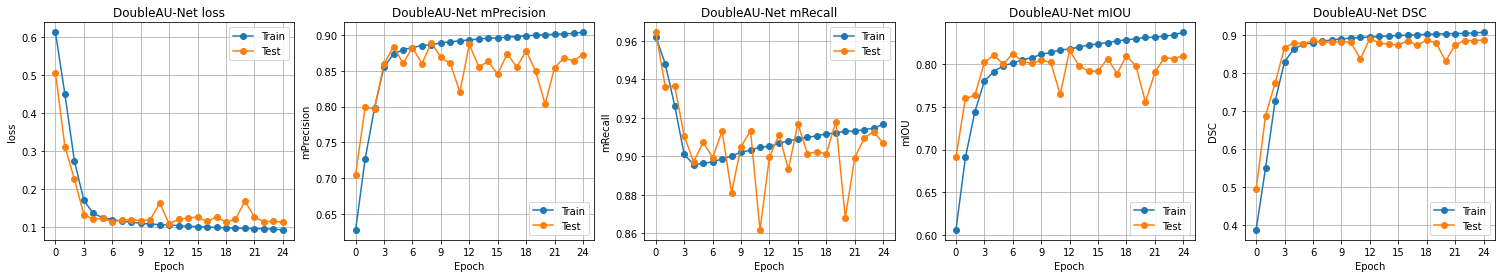

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, 5,)
fig.set_size_inches((26, 4))

#loss
i = 0
axs[i].plot (train_loss_arr , label = "Train" , marker='o')
axs[i].plot (valid_loss_epoch_arr , label = "Test" , marker='o')
axs[i].set_ylabel ('loss')
axs[i].set_title ('DoubleAU-Net loss')
axs[i].set_xlabel ('Epoch')

#mPrecision
i+=1
axs[i].plot (train_mPrecision_arr , label = "Train" , marker='o')
axs[i].plot (valid_mPrecision_arr , label = "Test" , marker='o')
axs[i].set_ylabel ('mPrecision')
axs[i].set_title ('DoubleAU-Net mPrecision')

#mRecall
i+=1
axs[i].plot (train_mRecall_arr , label = "Train" , marker='o')
axs[i].plot (valid_mRecall_arr , label = "Test" , marker='o')
axs[i].set_title ('DoubleAU-Net mRecall')
axs[i].set_ylabel ('mRecall')

#mIOU
i+=1
axs[i].plot (train_mIOU_arr , label = "Train" , marker='o')
axs[i].plot (valid_mIOU_arr , label = "Test" , marker='o')
axs[i].set_title ('DoubleAU-Net mIOU')
axs[i].set_ylabel ('mIOU')

#mDSC
i+=1
axs[i].plot (train_DSC_arr , label = "Train" , marker='o')
axs[i].plot (valid_DSC_arr , label = "Test" , marker='o')
axs[i].set_title ('DoubleAU-Net DSC')
axs[i].set_ylabel ('DSC')

for j in range(5):
  axs[j].set_xlabel ('Epoch')
  axs[j].xaxis.set_major_locator(MaxNLocator(integer=True))
  axs[j].legend()
  axs[j].grid()

# 10 Final model test

## 10.1 Load model function

In [ ]:
def load_model(model_path):
    #folder_in_output = '/09.09.2022 16:58:04/'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    DoubleUNet_model = DoubleUNet().to(device)
    loaded_model = DoubleUNet_model
    loaded_model.eval()
    loaded_model.load_state_dict(torch.load(model_path,map_location=torch.device(device)))
    loaded_model.eval()
    return loaded_model

  

## 10.2 Test function

In [ ]:
def final_test(model,valid_data,output_file_path):
    model.eval()
    valid_loss = 0
    mPrecision=0
    mRecall=0
    mIOU=0
    avg_batch_valid_DSC=0
    
    num_batches = len(valid_data)
    with torch.no_grad():
        for batch_idx,batch in enumerate(valid_data):
            # Getting the batch data:
            x = batch['image'].to(device) #GPU
            y = batch['mask'].to(device) # GPU

            # Getting predictions:
            y_pred = model(x)
            
            if config['dataset']=='CVC':
              batch_loss = bce_dice_loss(y,y_pred)
            elif config['dataset']=='bowl':
              batch_loss = dice_loss(y,y_pred)
              
            batch_valid_DSC = dice_coef(y,y_pred)

            #print(batch_loss)
            avg_batch_valid_DSC += batch_valid_DSC.sum()/(len(batch_valid_DSC))
            loss = batch_loss.sum()/(len(batch_loss))
            valid_loss+=loss #sums up all avg batch losses

            # Calculating Accuracy:
            precision, recall = calculate_prec_rec(y, y_pred)
            pred_iou = iou(y, y_pred)

            mPrecision+=precision.sum()/(len(precision)) #mean precision of a batch and sums them up
            mRecall+=recall.sum()/(len(recall)) #mean recall of a batch and sums them up
            mIOU+=pred_iou.sum()/(len(pred_iou)) #mean IOU of a batch and sums them up

    valid_loss /= num_batches
    valid_DSC = avg_batch_valid_DSC / num_batches
    print_both('\n~~~~~~~~~~~~~~~~~ Test Loss: {:.4f} ~~~~~~~~~~~~~~~~~\n'.format(valid_loss),output_file_path = output_file_path)
    print_both('mean Precision:{}   |    mean Recall:{}   |    mIOU:{}    |   DSC:{}\n'.format(mPrecision/ num_batches, mRecall/ num_batches, mIOU/ num_batches, valid_DSC),output_file_path = output_file_path)
    
    return valid_loss.item(), valid_DSC.item(), (mPrecision/ num_batches).item(), (mRecall/ num_batches).item(), (mIOU/ num_batches).item()

## 10.3 Test loaded model

In [ ]:
folder_in_output = '/10.10.2022 12:51:24/'
model_name = 'DoubleUNet.pth'
model_path = config['output_path']+folder_in_output+model_name
test_output_path = config['output_path']+folder_in_output+'final_test'+model_name+'.txt'

device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model = load_model(model_path)
loaded_model.eval()
#print(loaded_model)
#test_loss, test_DSC, test_mPrecision, test_mRecall, test_mIOU = final_test(loaded_model, test_dataloader, test_output_path)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

DoubleUNet(
  (encoder1): encoder1(
    (VGG_19): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

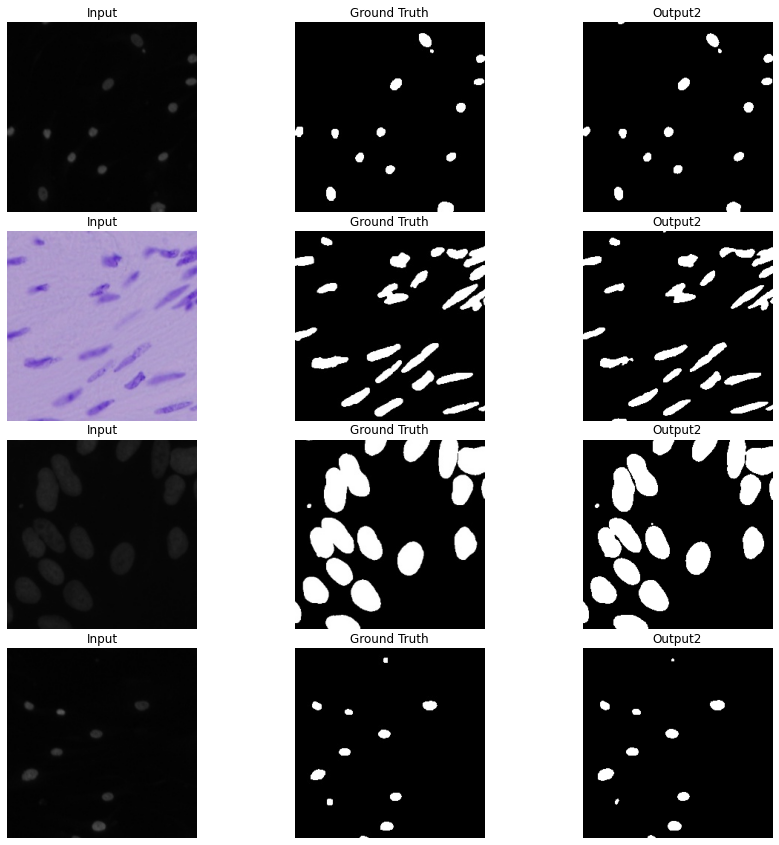

In [ ]:
batch = next(iter(test_dataloader))
x = batch['image'].to(device) #GPU
y = batch['mask'].to(device) # GPU
y_pred = loaded_model(x)
y_pred = torch.round(y_pred)


x = x.permute(0,2,3,1)
test_images= [cv2.cvtColor(x[i,:,:,:].cpu().detach().numpy(), cv2.COLOR_BGR2RGB) for i in range(0,config['batch_size'])]

figure = plt.figure(figsize=[15, 15])
figure.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(4):
  figure.add_subplot(4,3,3*i+1).set_aspect('equal')
  plt.title('Input')
  plt.axis('off')
  plt.imshow(test_images[i+6])
  figure.add_subplot(4,3,3*i+2).set_aspect('equal')
  plt.title('Ground Truth')
  plt.axis('off')
  plt.imshow(torchvision.utils.make_grid(y[i+6].cpu(), nrow=1).permute(1, 2, 0))
  figure.add_subplot(4,3,3*i+3).set_aspect('equal')
  plt.title('Output2')
  plt.axis('off')
  plt.imshow(torchvision.utils.make_grid(y_pred[i+6].cpu(), nrow=1).permute(1, 2, 0))

figure.subplots_adjust(wspace=0.1, hspace=0.1)


num of parameters:

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(loaded_model)

+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|   encoder1.VGG_19.features.0.weight    |    1728    |
|    encoder1.VGG_19.features.0.bias     |     64     |
|   encoder1.VGG_19.features.2.weight    |   36864    |
|    encoder1.VGG_19.features.2.bias     |     64     |
|   encoder1.VGG_19.features.5.weight    |   73728    |
|    encoder1.VGG_19.features.5.bias     |    128     |
|   encoder1.VGG_19.features.7.weight    |   147456   |
|    encoder1.VGG_19.features.7.bias     |    128     |
|   encoder1.VGG_19.features.10.weight   |   294912   |
|    encoder1.VGG_19.features.10.bias    |    256     |
|   encoder1.VGG_19.features.12.weight   |   589824   |
|    encoder1.VGG_19.features.12.bias    |    256     |
|   encoder1.VGG_19.features.14.weight   |   589824   |
|    encoder1.VGG_19.features.14.bias    |    256     |
|   encoder1.VGG_19.features.16.weight   |   589

154032546